# Deep Learning Project

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## Importing Libraries

In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import os
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import cv2 as cv

# Keras Hypertuner - Hyperband
from tensorflow.keras.optimizers import Adam 
from keras_tuner.tuners import Hyperband

# Custom Scripts
from utils import *
from models import model_example
from tuner_models import build_model, model_tuned

# QoL
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

Verifying if tensorflow is using the GPU

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Computing the time that has passed since a given start time

In [4]:
#Start Time
start_time = time.time()

## Importing Data

Creating a path

In [5]:
path = "."
#path = "/content/drive/MyDrive/DL Project" # Rui
#path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/DL Project' # David
#path = "/content/drive/MyDrive/bachelors/DL project/" # antonio

Loading Metadata and Images

In [6]:
metadata = pd.read_csv(path + '/HAM10000_metadata.csv')
train_img = os.listdir(path +"/train")

Visualising *metadata*

In [7]:
metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


Creating folders which will later be useful

In [8]:
# Create folder for blurred_images
blur_folder = "./new_data/blurred_images/"
os.makedirs(blur_folder, exist_ok=True)

# Create folder for dullRazor_images
dullRazor_folder = "./new_data/dullRazor_images/"
os.makedirs(dullRazor_folder, exist_ok=True)

# Create folder for circle_mask
circle_mask_folder = "./new_data/circle_mask_images/"
os.makedirs(dullRazor_folder, exist_ok=True)

# Create folder for test images
test_folder = "./new_data/test_folder"
os.makedirs(test_folder, exist_ok=True)

Creating folders and file for model checkpoint and model save

In [9]:
checkpoints_dir = path + "/models_checkpoints"

In [10]:
checkpoint_filepath = checkpoints_dir + "/model_checkpoint.h5"
best_model_savepath = checkpoints_dir + "/best_model.h5"

The *Metadata* dataframe includes information about the training and test set, whithout any specification.

To overcome this issue, in the cell below, the 'image_id' (i.e. the filename of each image) is used to identify which rows belong to the training set and the same regarding the test set. Thus, it is created a new column on the metadata named 'type', that specifies the set that the respective row corresponds to.

In [11]:
metadata["image_jpg"] = metadata["image_id"] + ".jpg"
metadata["type"] = metadata["image_jpg"].apply(lambda x: "train" if x in train_img else "test")

Dropping the variable *dx_type*, since it is not longer useful

In [12]:
metadata = metadata.drop("dx_type", axis = 1)

## Exploratory Data Analysis

Performing the *describe()* and *info()* methods

In [13]:
metadata.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [14]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   age           9958 non-null   float64
 4   sex           10015 non-null  object 
 5   localization  10015 non-null  object 
 6   image_jpg     10015 non-null  object 
 7   type          10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


Computing the Unique values for each column

In [15]:
for col in metadata.columns[1:]:
    unique_values = metadata[col].unique()
    print(f"Column {col}: {unique_values}\n")

Column image_id: ['ISIC_0027419' 'ISIC_0025030' 'ISIC_0026769' ... 'ISIC_0033536'
 'ISIC_0032854' 'ISIC_0032258']

Column dx: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']

Column age: [80. 75. 60. 70. 55. 85. 65. 40. 50. 45. 35.  0. 30. nan  5. 25. 20. 10.
 15.]

Column sex: ['male' 'female' 'unknown']

Column localization: ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']

Column image_jpg: ['ISIC_0027419.jpg' 'ISIC_0025030.jpg' 'ISIC_0026769.jpg' ...
 'ISIC_0033536.jpg' 'ISIC_0032854.jpg' 'ISIC_0032258.jpg']

Column type: ['train' 'test']



Using the *value_counts()* method for relevant variables

In [16]:
for col in metadata.columns[2:6]:
    count_values = metadata[col].value_counts()
    print(f"Column {col}: \n{count_values}\n")

Column dx: 
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Column age: 
age
45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
10.0      41
0.0       39
Name: count, dtype: int64

Column sex: 
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

Column localization: 
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64



#### Missing Values

In [17]:
metadata.isnull().sum()

lesion_id        0
image_id         0
dx               0
age             57
sex              0
localization     0
image_jpg        0
type             0
dtype: int64

Checking to see if the missing values in *age* are the same observations that have unknown *sex*

In [18]:
metadata[metadata['age'].isnull() & metadata['sex'] == 'unknown']

,lesion_id,image_id,dx,age,sex,localization,image_jpg,type


Filling the Missing Values in *age* with the mean of this variable

In [19]:
metadata['age'].fillna(metadata['age'].mean(), inplace=True)

#### Incoherencies

As we previously checked with the *value_counts()* method, gender appears to have some incoherent values

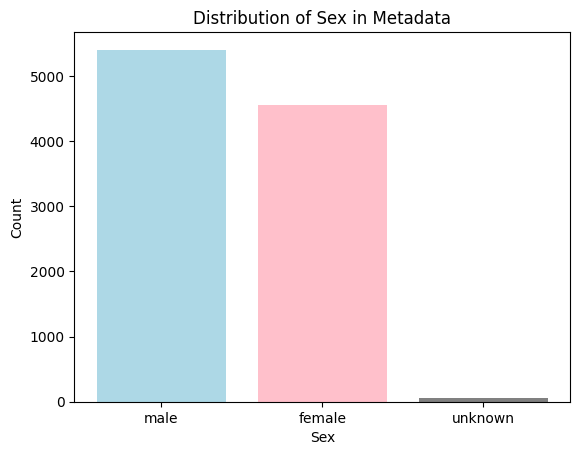

In [20]:
value_counts = metadata['sex'].value_counts()

# Plotting
plt.bar(value_counts.index, value_counts.values, color=['lightblue', 'pink', 'grey'])
plt.title('Distribution of Sex in Metadata')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

Looking for incoherencies in *age*

In [21]:
metadata[metadata['age'] == 0].count()

lesion_id       39
image_id        39
dx              39
age             39
sex             39
localization    39
image_jpg       39
type            39
dtype: int64

In [22]:
metadata[metadata['age'] == 0]

,lesion_id,image_id,dx,age,sex,localization,image_jpg,type
117,HAM_0007179,ISIC_0025906,bkl,0.0,female,back,ISIC_0025906.jpg,train
118,HAM_0007179,ISIC_0027151,bkl,0.0,female,back,ISIC_0027151.jpg,test
865,HAM_0006186,ISIC_0029320,bkl,0.0,male,lower extremity,ISIC_0029320.jpg,train
866,HAM_0006186,ISIC_0029427,bkl,0.0,male,lower extremity,ISIC_0029427.jpg,train
902,HAM_0004543,ISIC_0032170,bkl,0.0,female,back,ISIC_0032170.jpg,train
2388,HAM_0002610,ISIC_0026876,vasc,0.0,female,abdomen,ISIC_0026876.jpg,train
2389,HAM_0002610,ISIC_0030606,vasc,0.0,female,abdomen,ISIC_0030606.jpg,test
2398,HAM_0004542,ISIC_0024402,vasc,0.0,female,back,ISIC_0024402.jpg,train
2399,HAM_0004542,ISIC_0027256,vasc,0.0,female,back,ISIC_0027256.jpg,train
6683,HAM_0003246,ISIC_0029049,nv,0.0,male,ear,ISIC_0029049.jpg,test


In [23]:
metadata[metadata['age'] > 90]

,lesion_id,image_id,dx,age,sex,localization,image_jpg,type


#### Feature Engineering

Encoding *dx* and *localization*

In [25]:
label_encoder_dx = LabelEncoder()
label_encoder_loc = LabelEncoder()
metadata["dx_label"] = label_encoder_dx.fit_transform(metadata["dx"])
metadata["loc_label"] = label_encoder_loc.fit_transform(metadata["localization"])

### Outliers

Looking for outliers in the only numeric column

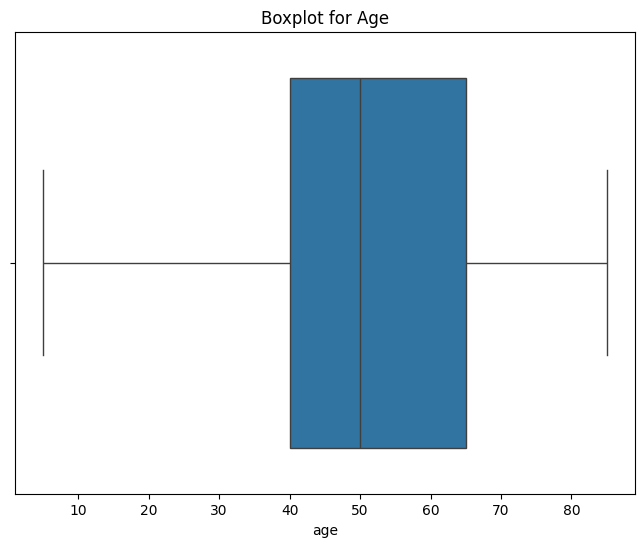

In [26]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=metadata['age'])
plt.title(f'Boxplot for Age')
plt.show()

### Visualisations

Plotting the Average Age per Gender

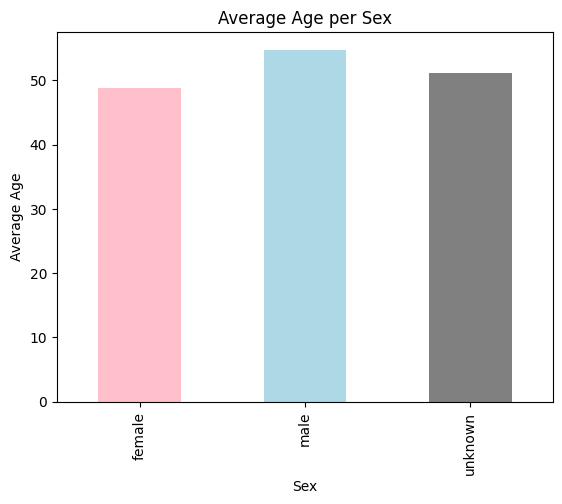

In [27]:
average_age_per_sex = metadata.groupby('sex')['age'].mean()

# Plotting
average_age_per_sex.plot(kind='bar', color=['pink', 'lightblue', 'grey'])
plt.title('Average Age per Sex')
plt.xlabel('Sex')
plt.ylabel('Average Age')
plt.show()

Plotting the Average Age per Cancer Location

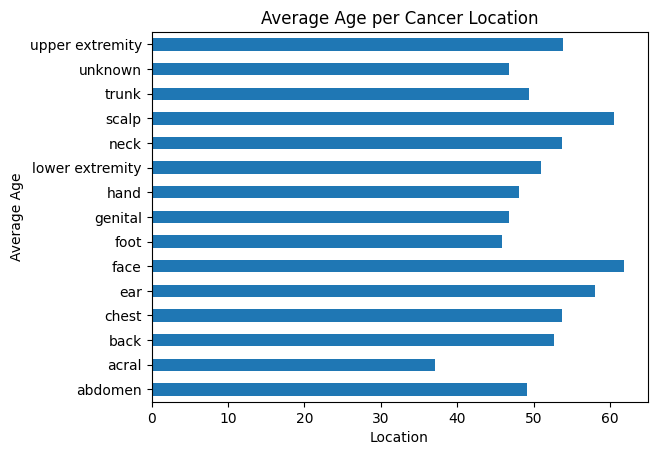

In [28]:
average_age_per_sex = metadata.groupby('localization')['age'].mean()

# Plotting
average_age_per_sex.plot(kind='barh')
plt.title('Average Age per Cancer Location')
plt.xlabel('Location')
plt.ylabel('Average Age')
plt.show()

Plotting the Diagnosis made per Location

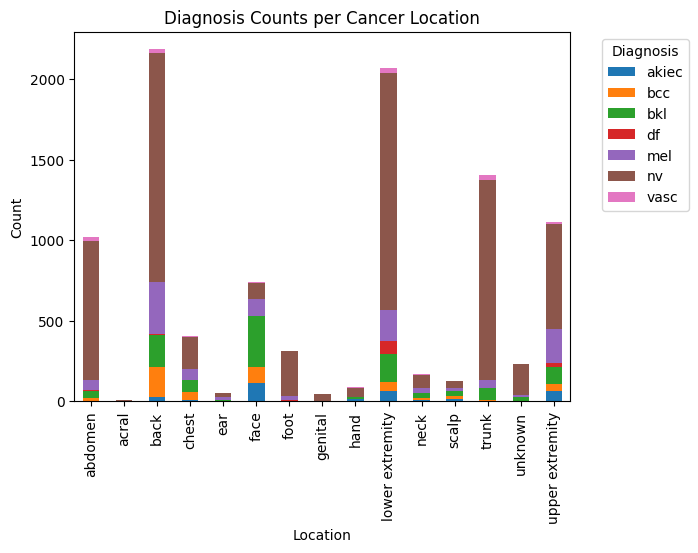

In [29]:
diagnosis_counts = metadata.groupby(['localization', 'dx']).size().unstack()

# Plotting
diagnosis_counts.plot(kind='bar', stacked=True)
plt.title('Diagnosis Counts per Cancer Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Split between train and test *metadata*

In [30]:
train = metadata[metadata["type"]=="train"]
test = metadata[metadata["type"]=="test"]

## Classification (1)

As a first step, we decided to fit a model without any image preprocessing.

Defining the image and batch sizes

In [31]:
#img_size = (112,150)
#batch_size= 100

Creating the Data Generators for train and validation

In [32]:
# Datagen for training
#train_datagen = ImageDataGenerator(
#    rescale=1./255,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    vertical_flip=True
#)

In [33]:
# Datagen for validation - just rescales the validation images
#val_datagen = ImageDataGenerator(
#    rescale=1./255
#)

Creating Callbacks

In [34]:
#model = model_example(img_size, metadata)

#checkpoint_filepath = checkpoints_dir + "/model_checkpoint"
#model_checkpoint_callback = ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    save_weights_only=True,
#    monitor="val_loss",
#    mode="min",
#    save_best_only=True
#)

#early_stopping = EarlyStopping(
#    monitor="val_loss",
#    mode="min",
#    patience=3,
#    restore_best_weights=True
#)

Performing train test split with Stratified K Fold

In [35]:
#stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#for fold, (train_index, val_index) in enumerate(stratified_kfold.split(train["image_jpg"], train["label"])):

#    print(f"Fold {fold + 1}")

    # Split for train and val
#    train_df = train.iloc[train_index]
#    val_df = train.iloc[val_index]

#    train_generator = train_datagen.flow_from_dataframe(
#        train_df,
#        directory= path+"/train",
#        x_col="image_jpg",
#        y_col="dx",
#        target_size=img_size,
#        batch_size=batch_size,
#        class_mode="categorical",
#        shuffle=True,
#        color_mode="rgb"
#    )

#    val_generator = val_datagen.flow_from_dataframe(
#        val_df,
#        directory=path+"/train",
#        x_col="image_jpg",
#        y_col="dx",
#        target_size=img_size,
#        batch_size=batch_size,
#        class_mode="categorical",
#        shuffle=False,
#        color_mode="rgb"
#    )

    # Train the model
#    history = model.fit(
#        train_generator,
#        epochs=150,
#        validation_data=val_generator,
#        callbacks=[model_checkpoint_callback,early_stopping]
#    )

    #Model End Time
#    tell_time(start_time, "Fold finished in:")

#    model.load_weights(checkpoint_filepath)

In [36]:
# Preprocess the test images
#testing_images = []
#for img_jpg in train["image_jpg"]:
#    img = image.load_img(os.path.join("./train", img_jpg ), target_size=img_size)
#    img_array = image.img_to_array(img)
#    img_array = np.expand_dims(img_array, axis=0)
#    img_array /= 255.0
#    testing_images.append(img_array)

#testing_images = np.vstack(testing_images)

# Predict
#predictions = model.predict(testing_images)
#predicted_labels = np.argmax(predictions, axis=1)
#train["predicted_labels"] = predicted_labels
# Accuracy
#accuracy = np.sum(predicted_labels == train['label']) / len(train)
#print(f'Accuracy: {accuracy}')

Looking at the results with a *classification report*

In [37]:
# Classification report
#report = classification_report(train["label"] , predicted_labels, target_names=label_encoder.classes_)
#print(report)

With our exploratory model done and its results evaluated, we decided to move on to Image Preprocessing

## Image Preprocessing

In this section of the project we will implement several image preprocessing techniques, aiming to improve the previously computed results

Defining the image and batch sizes

In [38]:
img_size = (112,150)
batch_size= 100 

Display of image preprocessing techniques

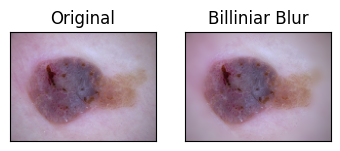

In [39]:
img_path = "./train/" + str(train["image_jpg"].sample().values[0])
show_blur(img_path, img_size)

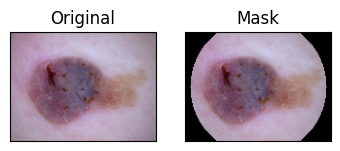

In [40]:
show_circle_mask(img_path, img_size)

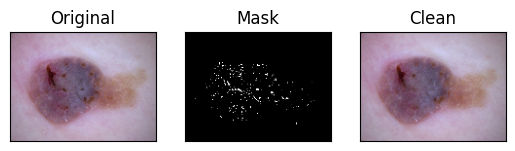

In [41]:
show_dullRazor(img_path, img_size)

Creating the Data Generators for train and validation

In [42]:
# Datagen for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [43]:
# Datagen for validation - just rescales the validation images
val_datagen = ImageDataGenerator(
    rescale=1./255
)

Fitting the train data generator

In [44]:
train_images = []
for image_path in train["image_jpg"]:

    img = cv.imread(dullRazor_folder + f"/{image_path}") # change folder here for different images preprocessing techniques
    img = cv.resize(img, (img_size[1], img_size[0]))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    train_images.append(img)

train_images = np.array(train_images)

train_datagen.fit(train_images)

## Classification (2)

Creating Callbacks

In [45]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True
)

Create Keras Tuner - Hyperband

In [46]:
# Create a Keras Tuner Hyperband tuner
#tuner = Hyperband(
#    build_model,
#    objective='val_loss',
#    max_epochs=50,  
#    factor=3,       
#    directory= checkpoints_dir,
#    project_name='tuner_example',
#    overwrite=True
#)

Build_model is a model modification of the model_example to work with Keras Tuner

Use Hyperband to find the best hyperparameters

In [47]:
#Model Fold Time
#tell_time(start_time, "Model training started at:")

# Stratified K-Fold
#stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through folds
#for fold, (train_index, val_index) in enumerate(stratified_kfold.split(train["image_jpg"], train["dx_label"])):
    
#    if fold > 0:
#        break
    
#    print(f"Fold {fold + 1}")

    # Split for train and val
#    train_df = train.iloc[train_index]
#    val_df = train.iloc[val_index]

    # Data augmentation
#    train_generator = train_datagen.flow_from_dataframe(
#        train_df,
#        directory=dullRazor_folder,
#        x_col="image_jpg",
#        y_col="dx",
#        target_size=img_size,
#        batch_size=batch_size,
#        class_mode="categorical",
#        shuffle=True,
#        color_mode="rgb"
#    )

#    val_generator = val_datagen.flow_from_dataframe(
#        val_df,
#        directory=dullRazor_folder,
#        x_col="image_jpg",
#        y_col="dx",
#        target_size=img_size,
#       batch_size=batch_size,
#        class_mode="categorical",
#        shuffle=False,
#        color_mode="rgb"
#    )
    
    # Search for the best hyperparameters
#    tuner.search(train_generator, epochs=50, validation_data=val_generator, callbacks=[model_checkpoint_callback, early_stopping])

Creation of a new model with the results of Keras Tuners

In [48]:
# Save best model
#best_hps = tuner.get_best_hyperparameters()[0]
#best_model = tuner.hypermodel.build(best_hps)

#best_hps.values returned:
#dict_best_hps = {
#    'Conv2D_1': 128,
#    'Dropout_1': 0.1,
#    'Conv2D_2': 128,
#    'Dropout_2': 0.2,
#    'Conv2D_3': 192,
#    'Dropout_3': 0.1,
#    'Conv2D_4': 192,
#    'Dropout_4': 0.4,
#    'Dense': 192,
#    'learning_rate': 0.001,
#    'tuner/epochs': 50,
#    'tuner/initial_epoch': 17,
#    'tuner/bracket': 1,
#    'tuner/round': 1,
#    'tuner/trial_id': '0077'
#     }

# We viewed the best parameters and created a model with them because the tuner had a run time of 2h

Training of model_tuned

In [49]:
best_model = model_tuned()

model_tuned was create using the best model resulted from Keras Tuner

Model Training

In [50]:
#Model Fold Time
tell_time(start_time, "Model training started at:")

#List of the acc and loss for plot
acc = []
val_acc = []
loss = []
val_loss = []

# Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through folds
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(train["image_jpg"], train["dx_label"])):
    
    print(f"Fold {fold + 1}")

    # Split for train and val
    train_df = train.iloc[train_index]
    val_df = train.iloc[val_index]

    # Data augmentation
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=dullRazor_folder,
        x_col="image_jpg",
        y_col="dx",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        color_mode="rgb"
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=dullRazor_folder,
        x_col="image_jpg",
        y_col="dx",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
        color_mode="rgb"
    )

    # Train the model with callbacks
    history = best_model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[model_checkpoint_callback, early_stopping])

    # Load the weights of the best model
    best_model.load_weights(checkpoint_filepath)
    
    #Append results for plot
    for value in history.history['accuracy']:
        acc.append(value)
        
    for value in history.history['val_accuracy']:
        val_acc.append(value)
        
    for value in history.history['loss']:
        loss.append(value)
        
    for value in history.history['val_loss']:
        val_loss.append(value)

    #Model Fold Time
    tell_time(start_time, f"Model finished Fold {fold + 1} after:")

# Save Model
best_model.save(best_model_savepath)

Model training started at: 0.22205619812011718
Fold 1
Found 5984 validated image filenames belonging to 7 classes.
Found 1497 validated image filenames belonging to 7 classes.
Epoch 1/50
60/60 [==============================] - 19s 256ms/step - loss: 1.1877 - accuracy: 0.6557 - val_loss: 1.0699 - val_accuracy: 0.6693
Epoch 2/50
60/60 [==============================] - 13s 221ms/step - loss: 1.0049 - accuracy: 0.6691 - val_loss: 0.9922 - val_accuracy: 0.6693
Epoch 3/50
60/60 [==============================] - 13s 218ms/step - loss: 0.9674 - accuracy: 0.6688 - val_loss: 1.0089 - val_accuracy: 0.6693
Epoch 4/50
60/60 [==============================] - 13s 217ms/step - loss: 0.9519 - accuracy: 0.6693 - val_loss: 0.9796 - val_accuracy: 0.6627
Epoch 5/50
60/60 [==============================] - 13s 219ms/step - loss: 0.9471 - accuracy: 0.6663 - val_loss: 0.9121 - val_accuracy: 0.6727
Epoch 6/50
60/60 [==============================] - 13s 218ms/step - loss: 0.9266 - accuracy: 0.6705 - val_lo

In [51]:
#Model End Time
tell_time(start_time, "Model training finished in:")

Model training finished in: 10.594130790233612


# Testing from train

Load model and predict the images from train folder

In [52]:
#best_model = load_model(best_model_savepath)

In [53]:
# Preprocess the test images
testing_images = []
for img_jpg in train["image_jpg"]:
    img = image.load_img(os.path.join(dullRazor_folder, img_jpg ), target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    testing_images.append(img_array)

testing_images = np.vstack(testing_images)

# Predict
predictions = best_model.predict(testing_images)
predicted_labels = np.argmax(predictions, axis=1)
train["predicted_labels"] = predicted_labels

# Accuracy
accuracy = np.sum(predicted_labels == train['dx_label']) / len(train)
print(f'Accuracy: {accuracy}')

234/234 [==============================] - 2s 7ms/step
Accuracy: 0.7535088891859377


Classification report

In [54]:
report = classification_report(train["dx_label"] , predicted_labels, target_names=label_encoder_dx.classes_)
print(report)

              precision    recall  f1-score   support

       akiec       0.48      0.31      0.37       245
         bcc       0.48      0.50      0.49       385
         bkl       0.61      0.29      0.40       820
          df       0.00      0.00      0.00        86
         mel       0.56      0.34      0.42       835
          nv       0.81      0.95      0.87      5006
        vasc       0.66      0.70      0.68       104

    accuracy                           0.75      7481
   macro avg       0.51      0.44      0.46      7481
weighted avg       0.72      0.75      0.72      7481



The best macro f1-score achieved was 0.53 and weighted f1-score was 0.76

Plot Training Accuracy and Loss

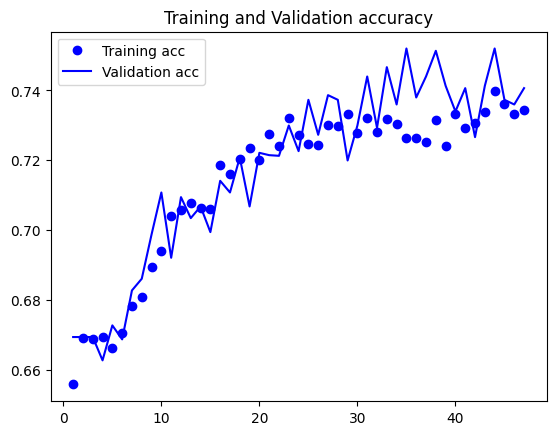

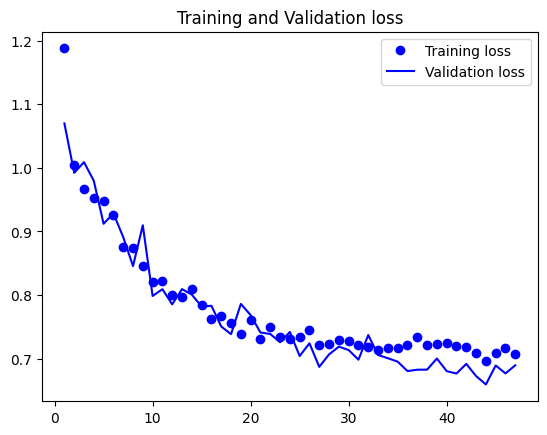

In [55]:
epochs = range (1, len (acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Predict Test

Load model and predict the images from test folder

In [56]:
#best_model = load_model(best_model_savepath)

In [57]:
# Preprocess the test images
testing_images = []
for img_jpg in test["image_jpg"]:
    img = image.load_img(os.path.join(test_folder, img_jpg ), target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    testing_images.append(img_array)

testing_images = np.vstack(testing_images)

# Predict
predictions = best_model.predict(testing_images)
predicted_labels = np.argmax(predictions, axis=1)
test["predicted_labels"] = predicted_labels

# Accuracy
accuracy = np.sum(predicted_labels == test['dx_label']) / len(test)
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 1s 13ms/step
Accuracy: 0.7486973947895792


Classification report

In [58]:
# Classification report
report = classification_report(test["dx_label"] , predicted_labels, target_names=label_encoder_dx.classes_)
print(report)

              precision    recall  f1-score   support

       akiec       0.35      0.21      0.26        82
         bcc       0.50      0.50      0.50       129
         bkl       0.60      0.27      0.37       274
          df       0.00      0.00      0.00        29
         mel       0.57      0.37      0.45       278
          nv       0.80      0.95      0.87      1669
        vasc       0.58      0.74      0.65        34

    accuracy                           0.75      2495
   macro avg       0.49      0.43      0.44      2495
weighted avg       0.71      0.75      0.72      2495

